In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import tensorflow as tf 


C:\Users\dkout\AppData\Local\Temp\ipykernel_5912\4267910396.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#standardization of data
from sklearn.preprocessing import StandardScaler
predictorScaler = StandardScaler()
targetScaler = StandardScaler()


In [3]:
# Load the data
df = pd.read_csv('Made2.csv')


In [4]:
#remove origin_destination_country

df = df.drop(['origin_destination_country'], axis=1)

In [5]:
#select only numerics
dfn = df.select_dtypes(include=[np.number])

In [6]:
#convert these columns to numeric using OneHotEncoding
#use 1,0 for True, False
df = pd.get_dummies(df, columns=['arrival_departure','scheduled_charter'])

#drop the columns that are not needed
df = df.drop(columns=['flights_unmatched_percent', 'flights_cancelled_percent'], axis=1)

In [7]:
#replace 1,0 for True, False for arrival_departure_D column
df['arrival_departure_A'] = df['arrival_departure_A'].replace({True: 1, False: 0})
df['arrival_departure_D'] = df['arrival_departure_D'].replace({True: 1, False: 0})
df['scheduled_charter_C'] = df['scheduled_charter_C'].replace({True: 1, False: 0})
df['scheduled_charter_S'] = df['scheduled_charter_S'].replace({True: 1, False: 0})

C:\Users\dkout\AppData\Local\Temp\ipykernel_5912\2843309183.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['arrival_departure_A'] = df['arrival_departure_A'].replace({True: 1, False: 0})
C:\Users\dkout\AppData\Local\Temp\ipykernel_5912\2843309183.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['arrival_departure_D'] = df['arrival_departure_D'].replace({True: 1, False: 0})
C:\Users\dkout\AppData\Local\Temp\ipykernel_5912\2843309183.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be remov

In [8]:
#show the airlines by its count
airlines_count = df['airline_name'].value_counts()

airlines_count

airline_name
RYANAIR                    12472
EASYJET UK LTD             10595
TUI AIRWAYS LTD             8609
BRITISH AIRWAYS PLC         6148
JET2.COM LTD                6072
                           ...  
HOP - BRIT AIR                 1
JET TIME                       1
WORLD2FLY PORTUGAL             1
JAZEERA AIRWAYS K.S.C.P        1
STAR EAST AIRLINES             1
Name: count, Length: 262, dtype: int64

In [9]:
#subset airlines that have count greater than 100
df_100 = df[df['airline_name'].isin(airlines_count[airlines_count > 5000].index)]

df_100.shape

(43896, 21)

In [10]:
# Remove duplicates based on the 'origin' and 'destination' and 'airline_name' columns
df_deduped = df.drop_duplicates(subset=['reporting_airport', 'origin_destination','airline_name'])

# Print the shape of the deduplicated DataFrame
print(df_deduped.shape)

(5742, 21)


In [11]:
#combine reporting_airport and origin_destination columns as Journey
from pandas import DataFrame, merge
df_deduped['journey'] = df_deduped['reporting_airport'] + ', ' + df_deduped['origin_destination']

C:\Users\dkout\AppData\Local\Temp\ipykernel_5912\323433510.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deduped['journey'] = df_deduped['reporting_airport'] + ', ' + df_deduped['origin_destination']


In [12]:
#remove strings in the parentheses

import re

def remove_parentheses_contents(text):
    return re.sub(r'\(.*?\)', '', text).strip().replace(',,', ',')

df_deduped['journey'] = df_deduped['journey'].apply(remove_parentheses_contents)

C:\Users\dkout\AppData\Local\Temp\ipykernel_5912\1541931187.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deduped['journey'] = df_deduped['journey'].apply(remove_parentheses_contents)


In [13]:
df_deduped.head()

,reporting_period,reporting_airport,origin_destination,airline_name,number_flights_matched,actual_flights_unmatched,number_flights_cancelled,flights_more_than_15_minutes_early_percent,flights_15_minutes_early_to_1_minute_early_percent,flights_0_to_15_minutes_late_percent,...,flights_between_61_and_120_minutes_late_percent,flights_between_121_and_180_minutes_late_percent,flights_between_181_and_360_minutes_late_percent,flights_more_than_360_minutes_late_percent,average_delay_mins,arrival_departure_A,arrival_departure_D,scheduled_charter_C,scheduled_charter_S,journey
0,202201,ABERDEEN,GDANSK,WIZZ AIR,4,0,0,0.000000,25.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,19.0,0,1,0,1,"ABERDEEN, GDANSK"
1,202201,ABERDEEN,BELFAST CITY (GEORGE BEST),LOGANAIR LTD,17,0,0,17.647059,35.294118,23.529412,...,0.000000,11.764706,0.000000,0.0,22.0,1,0,0,1,"ABERDEEN, BELFAST CITY"
3,202201,ABERDEEN,SUMBURGH,LOGANAIR LTD,56,0,3,15.254237,25.423729,25.423729,...,6.779661,3.389831,1.694915,0.0,23.0,1,0,0,1,"ABERDEEN, SUMBURGH"
4,202201,ABERDEEN,TENERIFE (SURREINA SOFIA),TUI AIRWAYS LTD,9,0,0,0.000000,44.444444,33.333333,...,0.000000,11.111111,0.000000,0.0,22.0,0,1,1,0,"ABERDEEN, TENERIFE"
5,202201,ABERDEEN,GENEVA,EASYJET UK LTD,5,0,0,0.000000,40.000000,20.000000,...,0.000000,0.000000,0.000000,0.0,18.0,0,1,0,1,"ABERDEEN, GENEVA"


In [14]:
#remove the columns that are not needed
df_deduped = df_deduped.drop(['reporting_airport','origin_destination'], axis=1)

In [15]:

dfn = df_deduped.select_dtypes(include=[np.number])
dfn.head()

,reporting_period,number_flights_matched,actual_flights_unmatched,number_flights_cancelled,flights_more_than_15_minutes_early_percent,flights_15_minutes_early_to_1_minute_early_percent,flights_0_to_15_minutes_late_percent,flights_between_16_and_30_minutes_late_percent,flights_between_31_and_60_minutes_late_percent,flights_between_61_and_120_minutes_late_percent,flights_between_121_and_180_minutes_late_percent,flights_between_181_and_360_minutes_late_percent,flights_more_than_360_minutes_late_percent,average_delay_mins,arrival_departure_A,arrival_departure_D,scheduled_charter_C,scheduled_charter_S
0,202201,4,0,0,0.000000,25.000000,0.000000,50.000000,25.000000,0.000000,0.000000,0.000000,0.0,19.0,0,1,0,1
1,202201,17,0,0,17.647059,35.294118,23.529412,5.882353,5.882353,0.000000,11.764706,0.000000,0.0,22.0,1,0,0,1
3,202201,56,0,3,15.254237,25.423729,25.423729,6.779661,10.169492,6.779661,3.389831,1.694915,0.0,23.0,1,0,0,1
4,202201,9,0,0,0.000000,44.444444,33.333333,0.000000,11.111111,0.000000,11.111111,0.000000,0.0,22.0,0,1,1,0
5,202201,5,0,0,0.000000,40.000000,20.000000,20.000000,20.000000,0.000000,0.000000,0.000000,0.0,18.0,0,1,0,1


In [16]:
#export to csv
dfn.to_csv('clean.csv', index=False)

In [17]:
#seperate target and features
target = dfn['average_delay_mins']
predictors = dfn.drop(['average_delay_mins'], axis=1)

In [18]:
#assign values to x and y
X = predictors.values
y = target.values

In [19]:
#install sk-learn library
#%pip install scikit-learn

In [20]:
#standardization of data
from sklearn.preprocessing import StandardScaler
predictorScaler = StandardScaler()
targetScaler = StandardScaler()


In [21]:
#Storing the fit object for later reference

predictorScalerFit = predictorScaler.fit(X)
targetScalerFit = targetScaler.fit(y.reshape(-1, 1))

In [22]:
#generating the standardized values of X and y
X = predictorScalerFit.transform(X)
y = targetScalerFit.transform(y.reshape(-1, 1))

In [23]:
#split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [24]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

print(y_test.shape)

(4019, 17)
(1723, 17)
(4019, 1)
(1723, 1)


# Building the network

In [25]:
from keras import layers
from keras.models import Sequential

In [26]:
import tensorflow as tf

In [27]:
# importing the libraries
from tensorflow import keras
#from tensorflow.keras import layers 
from keras.models import Sequential
from keras.layers import Dense

In [28]:
# Define number of features
num_features = 17

In [29]:
# create ANN model
model = Sequential()

In [30]:
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=5, input_dim=num_features, kernel_initializer='normal', activation='relu'))

In [31]:
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))

In [32]:
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))

In [33]:
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))

In [34]:
# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [35]:
# Fitting the ANN to the Training set
model.fit(X_train, y_train, 
        batch_size = 20, 
        epochs = 50, verbose=1)

Epoch 1/50

201/201 [==============================] - 4s 3ms/step - loss: 0.7503
Epoch 2/50
201/201 [==============================] - 1s 5ms/step - loss: 0.5011
Epoch 3/50
201/201 [==============================] - 1s 5ms/step - loss: 0.4336
Epoch 4/50
201/201 [==============================] - 0s 2ms/step - loss: 0.3924
Epoch 5/50
201/201 [==============================] - 0s 2ms/step - loss: 0.3663
Epoch 6/50
201/201 [==============================] - 1s 4ms/step - loss: 0.3474
Epoch 7/50
201/201 [==============================] - 1s 4ms/step - loss: 0.3324
Epoch 8/50
201/201 [==============================] - 1s 4ms/step - loss: 0.3201
Epoch 9/50
201/201 [==============================] - 1s 4ms/step - loss: 0.3100
Epoch 10/50
201/201 [==============================] - 1s 4ms/step - loss: 0.3006
Epoch 11/50
201/201 [==============================] - 1s 4ms/step - loss: 0.2932
Epoch 12/50
201/201 [==============================] - 1s 4ms/step - loss: 0.2855
Epoch 13/50
201/201 [===

# Finding best parameters using manual grid search

In [36]:
# Defining a function to find the best parameters for ANN
def FunctionFindBestParams(X_train, y_train, X_test, y_test):
    # Defining the list of hyper parameters to try
    batch_size_list=[5, 10, 15, 20]
    epoch_list  =   [5, 10, 50, 100]
    
    import pandas as pd
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    
    # initializing the trials
    TrialNumber=0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=5, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))

            # Defining the Second layer of the model
            model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))

            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))

            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer='adam')

            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)

            MAPE = np.mean(100 * (np.abs(y_test-model.predict(X_test))/y_test))
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
            
            SearchResultsData=pd.concat([SearchResultsData, pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE]],
                                                                    columns=['TrialNumber', 'Parameters', 'Accuracy'] )])
    return(SearchResultsData)

######################################
# Calling the function
ResultsData=FunctionFindBestParams(X_train, y_train, X_test, y_test)

54/54 [==============================] - 0s 2ms/step
1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 66.32419796033885


C:\Users\dkout\AppData\Local\Temp\ipykernel_5912\2827209689.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  SearchResultsData=pd.concat([SearchResultsData, pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE]],


54/54 [==============================] - 0s 1ms/step
2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 76.09530233662665
54/54 [==============================] - 0s 943us/step
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 69.31563172077729
54/54 [==============================] - 0s 2ms/step
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 79.21048768826662
54/54 [==============================] - 0s 3ms/step
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 66.86082520244533
54/54 [==============================] - 0s 2ms/step
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 66.02420349368512
54/54 [==============================] - 0s 3ms/step
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 75.49465348240234
54/54 [==============================] - 0s 1ms/step
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: 72.39269122401218
54/54 [==============================] - 0s 2ms/step
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: 76.23135902952373
54/54 [==========

<Axes: xlabel='Parameters'>

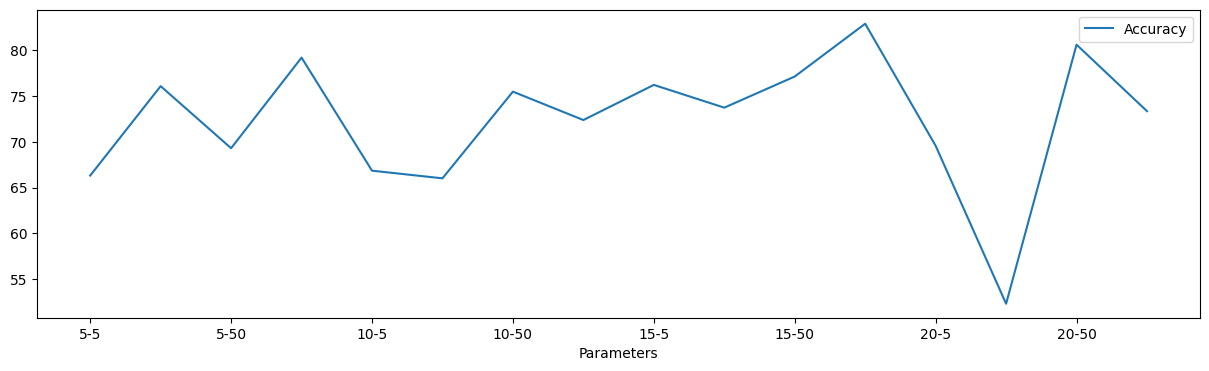

In [37]:
%matplotlib inline
ResultsData.plot(x='Parameters', y='Accuracy',figsize=(15,4), kind='line')

# Training the ANN model with best best parameter

In [38]:
#fitting the ANN to the training set
model.fit(X_train, y_train, batch_size = 15, epochs = 100, verbose=1)

Epoch 1/100
268/268 [==============================] - 1s 2ms/step - loss: 0.1806
Epoch 2/100
268/268 [==============================] - 0s 2ms/step - loss: 0.1776
Epoch 3/100
268/268 [==============================] - 0s 2ms/step - loss: 0.1788
Epoch 4/100
268/268 [==============================] - 0s 2ms/step - loss: 0.1761
Epoch 5/100
268/268 [==============================] - 0s 2ms/step - loss: 0.1744
Epoch 6/100
268/268 [==============================] - 1s 2ms/step - loss: 0.1729
Epoch 7/100
268/268 [==============================] - 0s 2ms/step - loss: 0.1722
Epoch 8/100
268/268 [==============================] - 0s 2ms/step - loss: 0.1713
Epoch 9/100
268/268 [==============================] - 0s 2ms/step - loss: 0.1725
Epoch 10/100
268/268 [==============================] - 0s 2ms/step - loss: 0.1682
Epoch 11/100
268/268 [==============================] - 0s 2ms/step - loss: 0.1688
Epoch 12/100
268/268 [==============================] - 0s 2ms/step - loss: 0.1671
Epoch 13/100


In [39]:
#generating predictions on the test set
Predictions = model.predict(X_test)

54/54 [==============================] - 0s 1ms/step


In [40]:
#scalinng back the predictions to original scale
Predictions = targetScalerFit.inverse_transform(Predictions)

In [41]:
#scaling back the y_test to original scale
y_test_orig = targetScalerFit.inverse_transform(y_test)

In [42]:
#scaling test data back to orginal
Test_data = predictorScalerFit.inverse_transform(X_test)

In [43]:
Testing_data = pd.DataFrame(data=Test_data, columns=predictors.columns)
Testing_data['Actual Mins'] = y_test_orig
Testing_data['PredictedMins'] = Predictions
Testing_data.head()

,reporting_period,number_flights_matched,actual_flights_unmatched,number_flights_cancelled,flights_more_than_15_minutes_early_percent,flights_15_minutes_early_to_1_minute_early_percent,flights_0_to_15_minutes_late_percent,flights_between_16_and_30_minutes_late_percent,flights_between_31_and_60_minutes_late_percent,flights_between_61_and_120_minutes_late_percent,flights_between_121_and_180_minutes_late_percent,flights_between_181_and_360_minutes_late_percent,flights_more_than_360_minutes_late_percent,arrival_departure_A,arrival_departure_D,scheduled_charter_C,scheduled_charter_S,Actual Mins,PredictedMins
0,202202.0,6.0,0.0,2.775558e-17,0.0,0.000000,83.333333,0.000000,0.000000,0.000000,0.000000,16.666667,0.0,0.0,1.0,1.0,0.0,39.0,41.372547
1,202205.0,117.0,0.0,2.775558e-17,0.0,14.529915,43.589744,21.367521,16.239316,3.418803,0.854701,0.000000,0.0,0.0,1.0,0.0,1.0,19.0,14.566278
2,202302.0,1.0,0.0,2.775558e-17,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.0,0.0,1.0,1.0,0.0,135.0,128.439438
3,202206.0,3.0,0.0,2.775558e-17,0.0,33.333333,33.333333,0.000000,0.000000,33.333333,0.000000,0.000000,0.0,1.0,0.0,0.0,1.0,22.0,29.614052
4,202206.0,1.0,0.0,2.775558e-17,0.0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.0,1.0,0.0,1.0,0.0,117.0,81.309570


# Find Accuracy

MAPE = mean absolute percentage error

In [44]:
#calcalate the absolute percent error
APE= 100*(abs(Testing_data['Actual Mins']-Testing_data['PredictedMins'])/Testing_data['Actual Mins'])
Testing_data['APE'] = APE

print(100-np.mean(APE))
Testing_data.head()

80.72199778906761


,reporting_period,number_flights_matched,actual_flights_unmatched,number_flights_cancelled,flights_more_than_15_minutes_early_percent,flights_15_minutes_early_to_1_minute_early_percent,flights_0_to_15_minutes_late_percent,flights_between_16_and_30_minutes_late_percent,flights_between_31_and_60_minutes_late_percent,flights_between_61_and_120_minutes_late_percent,flights_between_121_and_180_minutes_late_percent,flights_between_181_and_360_minutes_late_percent,flights_more_than_360_minutes_late_percent,arrival_departure_A,arrival_departure_D,scheduled_charter_C,scheduled_charter_S,Actual Mins,PredictedMins,APE
0,202202.0,6.0,0.0,2.775558e-17,0.0,0.000000,83.333333,0.000000,0.000000,0.000000,0.000000,16.666667,0.0,0.0,1.0,1.0,0.0,39.0,41.372547,6.083454
1,202205.0,117.0,0.0,2.775558e-17,0.0,14.529915,43.589744,21.367521,16.239316,3.418803,0.854701,0.000000,0.0,0.0,1.0,0.0,1.0,19.0,14.566278,23.335382
2,202302.0,1.0,0.0,2.775558e-17,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.0,0.0,1.0,1.0,0.0,135.0,128.439438,4.859676
3,202206.0,3.0,0.0,2.775558e-17,0.0,33.333333,33.333333,0.000000,0.000000,33.333333,0.000000,0.000000,0.0,1.0,0.0,0.0,1.0,22.0,29.614052,34.609326
4,202206.0,1.0,0.0,2.775558e-17,0.0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.0,1.0,0.0,1.0,0.0,117.0,81.309570,30.504641


In [45]:
Testing_data['Actual Mins'].max()

1285.0

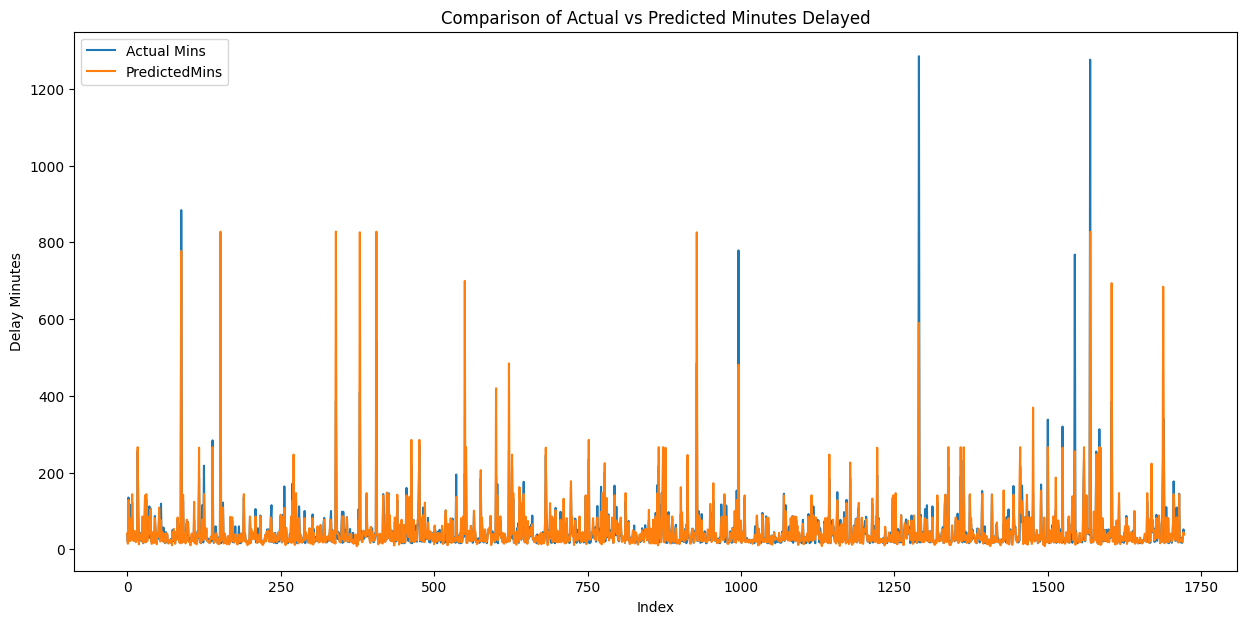

In [46]:
#plot the Mins and PredictedMins columns using line chart
plt.figure(figsize=(15, 7))
plt.plot(Testing_data['Actual Mins'], label='Actual Mins')
plt.plot(Testing_data['PredictedMins'], label='PredictedMins')
plt.xlabel('Index')
plt.ylabel('Delay Minutes')
plt.title("Comparison of Actual vs Predicted Minutes Delayed")
plt.legend()
plt.show()

find a way to predcit excatly unseen data to give the regr output

In [47]:
def predict_average_delay_mins(user_data_list, predictor_scaler):
    # Preprocess user data as a DataFrame
    user_df = pd.DataFrame(user_data_list)
    user_df.columns = predictors.columns
    
    # Standardize the user's data
    user_data_scaled = predictor_scaler.transform(user_df)
    
    # Generate predictions
    predictions = model.predict(user_data_scaled)
    
    # Scale back the predictions to the original scale
    predictions_original_scale = targetScaler.inverse_transform(predictions)
    
    # Find the average delay minutes
    average_delay_mins = np.mean(predictions_original_scale)
    
    return average_delay_mins

In [48]:
user_data_list = [
    {
        'reporting_period': 202206,
        'number_flights_matched': 1,
        'actual_flights_unmatched': 0,
        'number_flights_cancelled': 0,
        'flights_more_than_15_minutes_early_percent': 0,
        'flights_15_minutes_early_to_1_minute_early_percent': 0,
        'flights_0_to_15_minutes_late_percent': 0,
        'flights_between_16_and_30_minutes_late_percent': 0,
        'flights_between_31_and_60_minutes_late_percent': 0,
        'flights_between_61_and_120_minutes_late_percent': 100,
        'flights_between_121_and_180_minutes_late_percent': 0,
        'flights_between_181_and_360_minutes_late_percent': 0,
        'flights_more_than_360_minutes_late_percent': 0,
        'arrival_departure_A': 1,
        'arrival_departure_D': 0,
        'scheduled_charter_C': 0,
        'scheduled_charter_S': 1
    }
]

average_delay_mins = predict_average_delay_mins(user_data_list, predictorScalerFit)
print(f"The average delay minutes for the provided data is: {average_delay_mins:.2f}")

1/1 [==============================] - 0s 32ms/step
The average delay minutes for the provided data is: 85.85


d:\5th sem\DeepLearnig\ANN_two\atemp1\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [49]:
#save it a joblib variable
import joblib

# Save the model and scaler
joblib.dump(model, 'model.sav')
loaded_model = joblib.load('model.sav')
loaded_target = joblib.dump(targetScaler, 'target_scaler.sav')

# Find best hyperparameters

In [50]:

'''# Function to generate Deep ANN model 
def make_regression_ann(Optimizer_trial):
    from keras.models import Sequential
    from keras.layers import Dense
    
    model = Sequential()
    model.add(Dense(units=5, input_dim=17, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer=Optimizer_trial)
    return model'''

"# Function to generate Deep ANN model \ndef make_regression_ann(Optimizer_trial):\n    from keras.models import Sequential\n    from keras.layers import Dense\n    \n    model = Sequential()\n    model.add(Dense(units=5, input_dim=17, kernel_initializer='normal', activation='relu'))\n    model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))\n    model.add(Dense(1, kernel_initializer='normal'))\n    model.compile(loss='mean_squared_error', optimizer=Optimizer_trial)\n    return model"

In [51]:
'''import keras
print(keras.__file__)'''

'import keras\nprint(keras.__file__)'

**find this shit**:       keras.wrappers.scikit_learn

In [52]:
'''from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier'''

'from keras.models import Sequential\nfrom keras.layers import Dense\nfrom keras.wrappers.scikit_learn import KerasClassifier'

In [53]:
'''from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

# Listing all the parameters to try
Parameter_Trials={'batch_size':[10,20,30],
                    'epochs':[10,20],
                    'Optimizer_trial':['adam', 'rmsprop']
                }

# Creating the regression ANN model
RegModel=KerasRegressor(make_regression_ann, verbose=0)'''

"from sklearn.model_selection import GridSearchCV\nfrom keras.wrappers.scikit_learn import KerasRegressor\n\n# Listing all the parameters to try\nParameter_Trials={'batch_size':[10,20,30],\n                    'epochs':[10,20],\n                    'Optimizer_trial':['adam', 'rmsprop']\n                }\n\n# Creating the regression ANN model\nRegModel=KerasRegressor(make_regression_ann, verbose=0)"

In [54]:
'''from sklearn.metrics import make_scorer

# Defining a custom function to calculate accuracy
def Accuracy_Score(orig,pred):
    MAPE = np.mean(100 * (np.abs(orig-pred)/orig))
    print('#'*70,'Accuracy:', 100-MAPE)
    return(100-MAPE)

custom_Scoring=make_scorer(Accuracy_Score, greater_is_better=True)'''

"from sklearn.metrics import make_scorer\n\n# Defining a custom function to calculate accuracy\ndef Accuracy_Score(orig,pred):\n    MAPE = np.mean(100 * (np.abs(orig-pred)/orig))\n    print('#'*70,'Accuracy:', 100-MAPE)\n    return(100-MAPE)\n\ncustom_Scoring=make_scorer(Accuracy_Score, greater_is_better=True)"

In [55]:
# Creating the Grid search space
# See different scoring methods by using sklearn.metrics.SCORERS.keys()
'''grid_search=GridSearchCV(estimator=RegModel, 
                        param_grid=Parameter_Trials, 
                        scoring=custom_Scoring, 
                        cv=5)'''

'grid_search=GridSearchCV(estimator=RegModel, \n                        param_grid=Parameter_Trials, \n                        scoring=custom_Scoring, \n                        cv=5)'

In [56]:
# Measuring how much time it took to find the best params
'''import time
StartTime=time.time()

# Running Grid Search for different paramenters
grid_search.fit(X,y, verbose=1)

EndTime=time.time()
print("########## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes')

print('### Printing Best parameters ###')
grid_search.best_params_'''

'import time\nStartTime=time.time()\n\n# Running Grid Search for different paramenters\ngrid_search.fit(X,y, verbose=1)\n\nEndTime=time.time()\nprint("########## Total Time Taken: ", round((EndTime-StartTime)/60), \'Minutes\')\n\nprint(\'### Printing Best parameters ###\')\ngrid_search.best_params_'